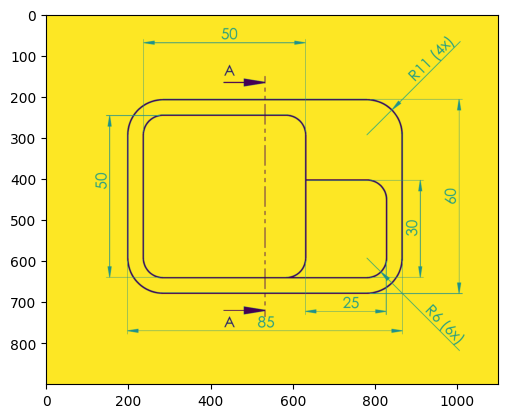

In [1]:
import cv2
from matplotlib import pyplot as plt

%matplotlib inline

input_view = cv2.imread("input_view.png", 0)
plt.imshow(input_view)
plt.show()

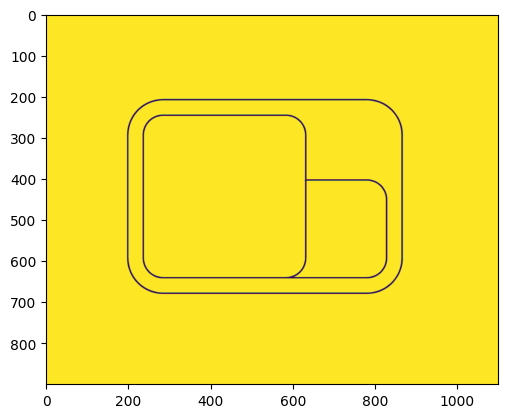

In [2]:
gt_view = cv2.imread("gt_view.png", 0)
plt.imshow(gt_view)
plt.show()

In [3]:
import os
import torch
from nnunetv2.inference.predict_from_raw_data import nnUNetPredictor

def init_unet():
    # Load and prepare UNet model for predictions
    nnUNet_results = "nnUNet_results"

    device = "cuda" if torch.cuda.is_available() else "cpu"

    predictor = nnUNetPredictor(
        tile_step_size=0.5,
        use_gaussian=True,
        use_mirroring=False, #True,
        perform_everything_on_device=True,
        device=torch.device(device),
        verbose=False,
        verbose_preprocessing=False,
        allow_tqdm=True,
    )

    predictor.initialize_from_trained_model_folder(
        os.path.join(nnUNet_results, "Dataset001_ViewSegmentation/nnUNetTrainer__nnUNetPlans__2d"),
        use_folds=["all"],
        checkpoint_name="checkpoint_final.pth",
    )

    return predictor

nnUNet_raw is not defined and nnU-Net can only be used on data for which preprocessed files are already present on your system. nnU-Net cannot be used for experiment planning and preprocessing like this. If this is not intended, please read documentation/setting_up_paths.md for information on how to set this up properly.
nnUNet_preprocessed is not defined and nnU-Net can not be used for preprocessing or training. If this is not intended, please read documentation/setting_up_paths.md for information on how to set this up.
nnUNet_results is not defined and nnU-Net cannot be used for training or inference. If this is not intended behavior, please read documentation/setting_up_paths.md for information on how to set this up.


In [4]:
import numpy as np

def apply_unet(image, predictor):
    w, h = image.shape
    
    # Calculate new dimensions capped at 512 pixels
    new_w = min(w, 512)
    new_h = min(h, 512)

    # Resize the image with aspect ratio preserved
    if h > w:
        scale = new_h / h
        new_w = int(w * scale)
    else:
        scale = new_w / w
        new_h = int(h * scale)

    resized_image = cv2.resize(image, (new_h, new_w), interpolation=cv2.INTER_AREA)

    # Prepare the image for UNet processing
    img = cv2.cvtColor(resized_image, cv2.COLOR_GRAY2RGB)
    img = np.moveaxis(img, -1, 0)
    img = img[:, np.newaxis, ...]
    img = img.astype(np.float32) / 255.0

    props = {"spacing": (999, 1, 1)}

    # Perform inference of the UNet model
    ret = predictor.predict_single_npy_array(img, props, None, None, False)
    prediction = np.squeeze(ret, axis=0)

    # Convert to cv2 image format
    shape_image = prediction.astype(np.uint8)
    prediction_image = shape_image.copy()
    shape_image[shape_image < 1.5] = 0
    shape_image[shape_image > 1.5] = 255
    shape_image = cv2.bitwise_not(shape_image)
    
    # Resize the image back to the original dimensions
    shape_image = cv2.resize(shape_image, (h, w), interpolation=cv2.INTER_LINEAR)
    
    return resized_image, prediction_image, shape_image

perform_everything_on_device=True is only supported for cuda devices! Setting this to False


100%|██████████| 1/1 [00:00<00:00,  1.26it/s]


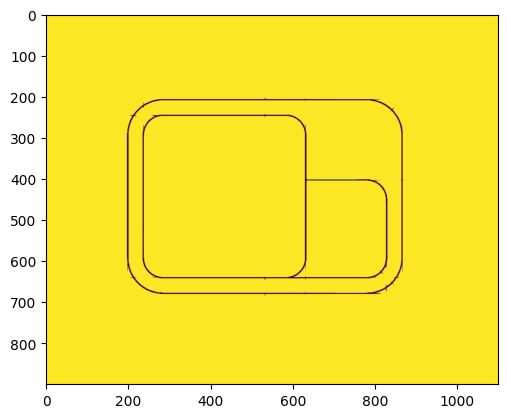

In [5]:
predictor = init_unet()
_, _, shape_image = apply_unet(input_view, predictor)
shape_image = cv2.bitwise_or(shape_image, (input_view > 128).astype(np.uint8) * 255)

%matplotlib inline

plt.imshow(shape_image)
plt.show()

In [6]:
def iou_and_dice(pred, gt):
    # Ensure binary (0/1)
    pred = (pred == 0).astype(np.uint8)
    gt = (gt == 0).astype(np.uint8)

    intersection = np.logical_and(pred, gt).sum()
    union = np.logical_or(pred, gt).sum()
    gt_sum = gt.sum()
    pred_sum = pred.sum()

    iou = intersection / union if union != 0 else 1.0
    dice = (2 * intersection) / (gt_sum + pred_sum) if (gt_sum + pred_sum) != 0 else 1.0

    return iou, dice

In [7]:
iou, dice = iou_and_dice(shape_image, gt_view)

print(f"IoU: {iou:.4f}")
print(f"Dice: {dice:.4f}")

IoU: 0.8268
Dice: 0.9052


In [8]:
def build_multiclass_gt(view_bin255, gt_shape_bin255):
    """
    view_bin255: uint8 image where 255=white (paper), 0=black (ink)
    gt_shape_bin255: uint8 image where 255=shape, 0=non-shape
    Returns gt labels in {0:bg, 1:clutter, 2:shape}
    """
    shape = gt_shape_bin255 == 0
    bg    = (view_bin255 == 255) & (~shape)
    clutter = (view_bin255 == 0) & (~shape)

    gt = np.zeros(view_bin255.shape, np.uint8)
    gt[bg] = 0
    gt[clutter] = 1
    gt[shape] = 2
    return gt

In [9]:
CLASSES = (0, 1, 2)  # 0=bg, 1=clutter, 2=shape

def iou_dice_per_class(gt, pred, classes=CLASSES):
    """
    gt, pred: int arrays with same shape, values in CLASSES
    Returns:
      per_class: {c: {"iou":..., "dice":..., "tp":..., "fp":..., "fn":...}}
      macro: {"miou_macro":..., "dice_macro":...}  (mean over classes, ignore NaN)
      micro: {"miou_micro":..., "dice_micro":...}  (global over all classes)
    """
    per_class = {}
    TP_sum = FP_sum = FN_sum = 0

    for c in classes:
        gt_c = (gt == c)
        pr_c = (pred == c)
        tp = np.logical_and(gt_c, pr_c).sum()
        fp = np.logical_and(~gt_c, pr_c).sum()
        fn = np.logical_and(gt_c, ~pr_c).sum()
        if tp + fp + fn == 0:
            iou = np.nan
            dice = np.nan
        else:
            iou  = tp / (tp + fp + fn)
            dice = (2 * tp) / (2 * tp + fp + fn)
        per_class[c] = {"iou": iou, "dice": dice, "tp": tp, "fp": fp, "fn": fn}
        TP_sum += tp; FP_sum += fp; FN_sum += fn

    # macro (ignore classes absent in both GT and pred)
    ious  = [per_class[c]["iou"]  for c in classes]
    dices = [per_class[c]["dice"] for c in classes]
    miou_macro  = np.nanmean(ious)
    dice_macro  = np.nanmean(dices)

    # micro (global)
    if (TP_sum + FP_sum + FN_sum) == 0:
        miou_micro = np.nan
        dice_micro = np.nan
    else:
        miou_micro = TP_sum / (TP_sum + FP_sum + FN_sum)
        dice_micro = (2 * TP_sum) / (2 * TP_sum + FP_sum + FN_sum)

    return per_class, {"miou_macro": miou_macro, "dice_macro": dice_macro}, {"miou_micro": miou_micro, "dice_micro": dice_micro}

In [10]:
ROOT = "test_data"

BG, CLUTTER, SHAPE = 0, 1, 2

# collectors
shape_iou_list, shape_dice_list   = [], []
clutter_iou_list, clutter_dice_list = [], []

view_count = 0
macro_iou_sum = macro_dice_sum = 0.0
micro_tp = micro_fp = micro_fn = 0

for path in os.listdir(ROOT):
    if not path.startswith("img"):
        continue

    # Load images
    view = cv2.imread(os.path.join(ROOT, path), cv2.IMREAD_GRAYSCALE)
    gt_view = cv2.imread(os.path.join(ROOT, path.replace("img", "seg")), cv2.IMREAD_GRAYSCALE)

    # Binarize: white=255, black=0
    view_bin = (view > 248).astype(np.uint8) * 255
    gt_shape_bin = (gt_view > 248).astype(np.uint8) * 255

    # Build multiclass GT
    gt_multi = build_multiclass_gt(view_bin, gt_shape_bin)

    # Predict
    resized_image, prediction_image, shape_image = apply_unet(view, predictor)
    # Ensure `prediction_image` is the same size as GT and in {0,1,2}
    if prediction_image.shape != gt_multi.shape:
        prediction_image = cv2.resize(prediction_image, (gt_multi.shape[1], gt_multi.shape[0]), interpolation=cv2.INTER_NEAREST)
    pred_multi = prediction_image.astype(np.int32)

    per_class, macro, micro = iou_dice_per_class(gt_multi, pred_multi, classes=(BG, CLUTTER, SHAPE))

    # per-class
    shape_iou_list.append(per_class[SHAPE]["iou"])
    shape_dice_list.append(per_class[SHAPE]["dice"])
    clutter_iou_list.append(per_class[CLUTTER]["iou"])
    clutter_dice_list.append(per_class[CLUTTER]["dice"])

    # macro-average (foreground classes)
    macro_fg_iou_img  = np.nanmean([per_class[CLUTTER]["iou"],  per_class[SHAPE]["iou"]])
    macro_fg_dice_img = np.nanmean([per_class[CLUTTER]["dice"], per_class[SHAPE]["dice"]])
    macro_iou_sum  += macro_fg_iou_img
    macro_dice_sum += macro_fg_dice_img

    # micro-average
    for c in (BG, CLUTTER, SHAPE):
        micro_tp += per_class[c]["tp"]
        micro_fp += per_class[c]["fp"]
        micro_fn += per_class[c]["fn"]

    view_count += 1

def m(x):  # mean ignoring NaN
    x = np.array(x, dtype=float)
    return float(np.nanmean(x)) if x.size else float("nan")

mean_iou_macro_fg  = macro_iou_sum / view_count
mean_dice_macro_fg = macro_dice_sum / view_count
miou_micro_all  = micro_tp / (micro_tp + micro_fp + micro_fn) if (micro_tp + micro_fp + micro_fn) else float("nan")
dice_micro_all  = (2*micro_tp) / (2*micro_tp + micro_fp + micro_fn) if (2*micro_tp + micro_fp + micro_fn) else float("nan")

print(f"Views: {view_count}")
print(f"Shape   IoU/Dice:   {np.nanmean(shape_iou_list):.2f} / {np.nanmean(shape_dice_list):.2f}")
print(f"Clutter IoU/Dice:   {np.nanmean(clutter_iou_list):.2f} / {np.nanmean(clutter_dice_list):.2f}")
print(f"Macro-FG IoU/Dice:  {mean_iou_macro_fg:.2f} / {mean_dice_macro_fg:.2f}")
print(f"Micro    IoU/Dice:  {miou_micro_all:.2f} / {dice_micro_all:.2f}")

100%|██████████| 1/1 [00:00<00:00,  1.77it/s]

Views: 18
Shape   IoU/Dice:   0.70 / 0.82
Clutter IoU/Dice:   0.63 / 0.76
Macro-FG IoU/Dice:  0.67 / 0.79
Micro    IoU/Dice:  0.94 / 0.97
